文本摘要

假设您有一组文档（PDF、Notion 页面、客户问题等），并且您想总结其内容。

鉴于大型语言模型在理解和合成文本方面的熟练程度，它们是完成这项工作的绝佳工具。

在检索增强生成的背景下，总结文本可以帮助提炼大量检索到的文档中的信息，从而为大型语言模型提供上下文。

在本演练中，我们将介绍如何使用大型语言模型总结多个文档中的内容。

In [7]:
import getpass
import os

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

 ········


In [8]:
%pip install --upgrade --quiet tiktoken langchain langgraph beautifulsoup4 langchain-community

# Set env var OPENAI_API_KEY or load from a .env file
# import dotenv

# dotenv.load_dotenv()

Note: you may need to restart the kernel to use updated packages.


In [9]:
import os

os.environ["LANGSMITH_TRACING"] = "true"

In [10]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://lilianweng.github.io/posts/2023-06-23-agent/")
docs = loader.load()

In [11]:
import getpass
import os

if not os.environ.get("DEEPSEEK_API_KEY"):
  os.environ["DEEPSEEK_API_KEY"] = getpass.getpass("Enter API key for DeepSeek: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("deepseek-chat", model_provider="deepseek")

In [12]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

This article provides a comprehensive overview of building autonomous agents using Large Language Models (LLMs) as the core controller. It outlines the key components, presents case studies, and discusses current challenges.

### Agent System Overview
An LLM-powered autonomous agent system uses the LLM as the brain, supported by three core components:
1.  **Planning:** Breaking down complex tasks into subgoals and engaging in self-reflection to learn from mistakes.
2.  **Memory:** Utilizing both short-term (in-context learning) and long-term (external vector stores) memory to retain and recall information.
3.  **Tool Use:** Calling external APIs to access information or capabilities not contained within the model's weights (e.g., current data, code execution).

### Component One: Planning
*   **Task Decomposition:** Techniques like **Chain of Thought (CoT)** and **Tree of Thoughts** help the model break down problems into manageable steps.
*   **Self-Reflection:** Frameworks like **ReA

In [12]:
# 可以逐个标记地流式传输结果
for token in chain.stream({"context": docs}):
    print(token, end="|")

|This| blog| post| by| Lil|ian| W|eng| provides| a| comprehensive| overview| of| building| autonomous| agents| powered| by| Large| Language| Models| (|LL|Ms|).| It| breaks| down| the| agent| system| into| three| core| components| and| discusses| real|-world| applications| and| challenges|.

|###| Core| Components| of| an| LL|M|-P|owered| Agent|

|1|.| | **|Planning|:**| The| agent|'s| ability| to| break| down| complex| tasks| and| learn| from| its| actions|.
|   | *|  | **|Task| De|composition|:**| Techniques| like| Chain| of| Thought| (|Co|T|)| and| Tree| of| Thoughts| help| the| model| "|think| step| by| step|"| and| explore| multiple| reasoning| paths|.
|   | *|  | **|Self|-|Ref|lection|:**| Fram|eworks| like| Re|Act| (|which| combines| reasoning| and| acting|)| and| Reflex|ion| allow| the| agent| to| critique| its| past| actions|,| learn| from| mistakes|,| and| improve| future| decisions|.

|2|.| | **|Memory|:**| The| agent|'s| capacity| to| store| and| retrieve| information|.
|   

# Map-Reduce：通过并行化总结长文本
深入了解 MapReduce 方法。为此，我们首先使用 LLM 将每个文档映射到单独的摘要。然后，我们将这些摘要“reduce”或合并成一个单一的全局摘要。

请注意，映射步骤通常在输入文档上并行化。

In [13]:
from langchain_core.prompts import ChatPromptTemplate

map_prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

In [14]:
from langchain import hub

map_prompt = hub.pull("rlm/map-prompt")

In [15]:
# Also available via the hub: `hub.pull("rlm/reduce-prompt")`
reduce_template = """
The following is a set of summaries:
{docs}
Take these and distill it into a final, consolidated summary
of the main themes.
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

In [16]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 1003, which is longer than the specified 1000


Generated 13 documents.


In [18]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.types import Send
from langgraph.graph import END, START, StateGraph

token_max = 1000


def length_function(documents: List[Document]) -> int:
    """Get number of tokens for input contents."""
    return sum(llm.get_num_tokens(doc.page_content) for doc in documents)


# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]


def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

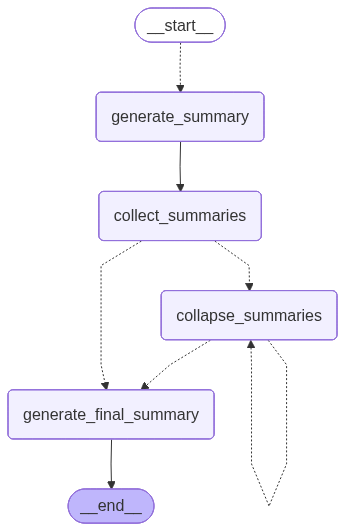

In [19]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [20]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['collapse_summaries']
['collapse_summaries']
['collapse_summaries']
['generate_final_summary']


In [21]:
print(step)

{'generate_final_summary': {'final_summary': 'Of course. Based on the provided summaries, here is a consolidated and distilled overview of the main themes describing the evolution and architecture of advanced AI agents.\n\n### **Core Paradigm Shift: From Static Models to Dynamic Agents**\nThe fundamental evolution is a move away from standalone Large Language Models (LLMs) toward **LLM-Powered Autonomous Agent Systems**. In this new paradigm, the LLM acts as an intelligent "brain" that orchestrates a broader ecosystem of capabilities to solve complex, real-world problems autonomously.\n\n### **The Three Pillars of Agent Architecture**\nThe technical foundation of these agents rests on three interconnected components:\n\n1.  **Reasoning & Planning:** The ability to decompose complex, long-horizon goals into manageable sub-tasks using advanced reasoning techniques.\n2.  **Memory:** A dual-system comprising short-term (contextual) and long-term (external database) memory to store and retr